In [41]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import fa2
import jiggle
import random


In [54]:
def load_file(file_path):
#     data_path = "../../data/ground-truth/Sparse/n=200d=6"
    f = open(file_path)
    edge_list = []
    data_list = []
    for line in f.readlines():
        data_list.append(line.strip())
    num_nodes = int (data_list.pop(0)) #Pop out the number of nodes 

    for i in range(num_nodes+1,len(data_list)):
        edge_list.append(tuple([int(data_list[i].strip('\n').split(" ")[0]), int(data_list[i].strip('\n').split(" ")[1])]))
    return edge_list, file_path.split("/")[-1]

In [55]:
def store(graph, target_graph_path):
    nx.write_graphfile(graph, target_graph_path)


In [56]:
def fr(edges_list,type):
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define spring layout and draw graph
    pos_dict = nx.fruchterman_reingold_layout(G, k=0.3, iterations=100)
    nx.draw(G, pos_dict, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
    
    for num, pos in pos_dict.items():
        
    # Set edge weights and draw graph
    nx.draw_networkx_edges(G, pos_dict, width=weights)

    return pos, G

In [57]:
def kk(edges_list, type):
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define Kamada-Kawai layout and draw graph
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
        
    # Set edge weights and draw graph
    nx.draw_networkx_edges(G, pos, width=weights)
    plt.show()
    return pos, G

In [58]:


def fa2(edges_list, type):
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define ForceAtlas2 layout and draw graph
    forceatlas2 = ForceAtlas2(
        # Parameters can be adjusted based on preference
        outboundAttractionDistribution=False,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        multiThreaded=False,
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0
    )
    positions = forceatlas2.forceatlas2_networkx_layout(G)
    nx.draw(G, positions, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
        
    # Set edge weights and draw graph
    nx.draw_networkx_edges(G, positions, width=weights)
    plt.show()
    return positions, G

In [59]:


# Define function to create graph
def jiggle(edges_list, type):
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define JIGGLE layout and draw graph
    jiggle = jiggle.JiggleLayout(G)
    jiggle.run()
    positions = jiggle.getPos()
    nx.draw(G, positions, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
        
    # Set edge weights and draw graph
    nx.draw_networkx_edges(graph, positions, width=weights)
    return positions, G


In [62]:
def generate(file_path, target_graph_path):
    edge_list, fname = load_file(file_path)
    print(edge_list)
    target_Sparse_path = os.path.join(target_graph_path, "Sparse")
    target_Uniform_path = os.path.join(target_graph_path, "Unifrom")
    type_list = ["Sparse", "Uniform"]
    for type in type_list:

        fr_path = os.path.join(type,"FR",fname+".graph")
        pos, graph = fr(edge_list, type)
        print(graph)
        print(pos)
        store(graph, fr_path)

        fa2_path = os.path.join(type,"FA2",fname+".graph")
        pos, graph = fa2(edge_list, type)
        store(graph, fa2_path)

        kk_path = os.path.join(type,"KK",fname+".graph")
        pos, graph = kk(edge_list, type)
        store(graph, kk_path)

        jiggle_path = os.path.join(type,"JIGGLE",fname+".graph")
        pos, graph = jiggle(edge_list, type)
        store(graph, jiggle_path)




[(0, 71), (0, 120), (0, 124), (0, 179), (0, 180), (1, 11), (1, 38), (1, 39), (1, 46), (1, 51), (1, 79), (1, 137), (1, 166), (1, 176), (2, 193), (3, 53), (3, 96), (3, 125), (3, 152), (4, 5), (4, 20), (4, 78), (4, 90), (4, 92), (4, 140), (4, 156), (5, 34), (5, 78), (5, 187), (6, 13), (6, 31), (6, 33), (6, 61), (6, 69), (6, 98), (6, 157), (7, 36), (7, 40), (7, 72), (7, 114), (7, 116), (7, 123), (7, 147), (7, 167), (7, 190), (8, 23), (8, 87), (8, 134), (8, 146), (8, 177), (8, 197), (9, 22), (9, 61), (9, 73), (9, 145), (9, 182), (10, 39), (10, 50), (11, 39), (11, 46), (11, 51), (11, 79), (11, 166), (11, 176), (11, 197), (12, 19), (12, 67), (12, 70), (12, 93), (12, 132), (12, 170), (13, 20), (13, 33), (13, 61), (13, 73), (13, 156), (14, 44), (14, 101), (14, 105), (14, 172), (14, 179), (15, 30), (15, 40), (15, 65), (15, 94), (15, 99), (15, 167), (16, 27), (16, 58), (16, 62), (16, 75), (16, 82), (16, 104), (16, 108), (16, 163), (17, 36), (17, 101), (17, 114), (17, 123), (17, 124), (17, 147), (

AttributeError: module 'networkx' has no attribute 'write_graphfile'

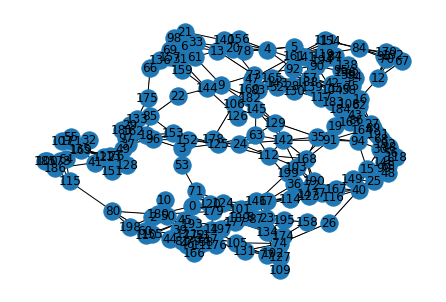

In [63]:
generate("../../Data/ground-truth/Sparse/n=200d=6","../../Data/new_graph_file_by_kevin")